# Calculating the Moment 0 Map

## Introduction
Computing the line intensity (moment-0) based on a 3D data cube is a fundamental operation. In this tutorial, we will learn how to generate a 3D mask and then integrate the cube along the spectral axis to obtain a robust moment-0 measurement. This tutorial is aimed at undergraduate and graduate students with a background in astrophysics.

## Learning Objectives
1. Determine the noise of a 3D data cube.
2. Learn how to define a signal mask indicating where signal is detected.
3. Calculate the moment-0 mask using a signal mask

## Background:
### The line emission profile ###

In astronomy, we commonly find line emission profiles, that can we described by a single Gaussian-shaped spectrum (or a combination thereof) that has the following functional form:
$$
S(v) = A \exp\left[-\frac{(v-v_0)^2}{2\sigma_v^2}\right],
$$
In this formula, $A$ describes the *amplitude*, $v_0$ the *centroid velocity* of the line profile, and $\sigma_v$ the *line width*.

In reality, the emisison we measure is best described by an additional noise component, which follows a Gaussian _distribution_ as well:
$$
T(v) = S(v) + \mathcal{N}(0, \sigma_{\textrm{noise}})
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

**Define generic spectrum**

In [45]:
#define Gaussian profile
A = 1
v0 = 0
sigma_v = 1

#Define axis
x_axis=np.linspace(-20,20,200)
delta_v = abs(x_axis[1]-x_axis[0])

#spec: The ideal spectrum
spec = A*np.exp(-(x_axis-v0)**2/sigma_v**2)

#spec_noise: Add noise from normal distribution
sigma_noise = 0.1
spec_noise = spec +np.random.normal(0,sigma_noise, len(x_axis))

#spec_noise_realistic: The sensitivity might decrease towards channesl at the edge, increasing the noise
spec_noise_realistic = spec_noise + np.random.normal(0, abs(x_axis/20)**3)

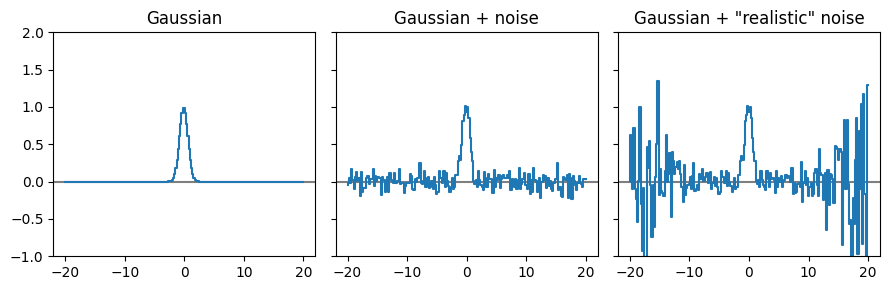

In [46]:
plt.figure(figsize=(9,3))
ax = plt.subplot(1,3,1)
ax.step(x_axis, spec)
ax.set_ylim(-1,2)
ax.axhline(0, zorder=0, color='k', alpha=.5)
ax.set_title('Gaussian')

ax = plt.subplot(1,3,2)
ax.step(x_axis, spec_noise)
ax.set_ylim(-1,2)
ax.set_yticklabels([])
ax.axhline(0, zorder=0, color='k', alpha=.5)
ax.set_title('Gaussian + noise')

ax = plt.subplot(1,3,3)
ax.step(x_axis, spec_noise_realistic)
ax.set_ylim(-1,2)
ax.set_yticklabels([])
ax.axhline(0, zorder=0, color='k', alpha=.5)
ax.set_title('Gaussian + "realistic" noise')
plt.tight_layout()

### Integrated Intensity -- Moment 0 ###

The most common product is the integrated intensity, or the zeroth moment. This is defined as the integral of $S(v)$, or equivalently the sum over the signal in the observed spectrum:
$$
M_0 = \int_{\mathrm{line}} T(v)\,dv \approx \sum_{i\in\{\mathrm{line}\}} T(v_i)\,\delta v,
$$
where $\delta v$ is the channel width in the cube. To improve the S/N, we define a mask that includes channels where we expect line emission (here defined as $\{\mathrm{line}\}$) and only sum over these.

The integrated intensity units in this case is K km/s.


### Simplest Calculation: Integrating over the whole spectrum

Integrating over the entire spectrum is the easiest way to determine the moment-0. However, since we integrate over the noise, the resulting S/N might be lower.

In [54]:
moment_0_spec = np.nansum(spec)*delta_v
moment_0_spec_noise = np.nansum(spec_noise)*delta_v
moment_0_spec_noise_real = np.nansum(spec_noise_realistic)*delta_v

print('Moment-0 ideal spectrum:\t\t %.3f [a.u]'%moment_0_spec )
print('Moment-0 simple noise spectrum:\t\t %.3f [a.u]'%moment_0_spec_noise )
print('Moment-0 ralistic noise spectrum:\t %.3f [a.u]'%moment_0_spec_noise_real )

Moment-0 ideal spectrum:		 1.772 [a.u]
Moment-0 simple noise spectrum:		 1.668 [a.u]
Moment-0 ralistic noise spectrum:	 1.966 [a.u]


**We see that the integrated intensities vary by 10-20\% in the case of large noise. Therefore, defining a mask will make the measurements less sensitive to the noise:**

### Defining a 1D Mask

The mask determination consists of the following steps:

i) Determine the channel noise (rms)

ii) Determine the channels (in 3D the voxels) who's values is above the noise.

iii) Improve the mask by removing spurious false positives.

**Step 1:** Determine the rms

* First we calculate the standard deviation (using the mean absolute deviation, which is more robust to outliers). This will overestimate the noise, since the presence of a line will bias the rms towards larger values.
* We perform a clipping and caluclate the rms again. This ensures that the majority of the line emission is not included anymore.

In [64]:
from astropy.stats import mad_std


rms_spec = mad_std(spec_noise)
rms_spec = mad_std(spec_noise[spec_noise<3*rms_spec])

rms_spec_realnoise = mad_std(spec_noise_realistic)
rms_spec_realnoise = mad_std(spec_noise_realistic[spec_noise_realistic<3*rms_spec])

**Plot the spectra and show the calculated rms:**

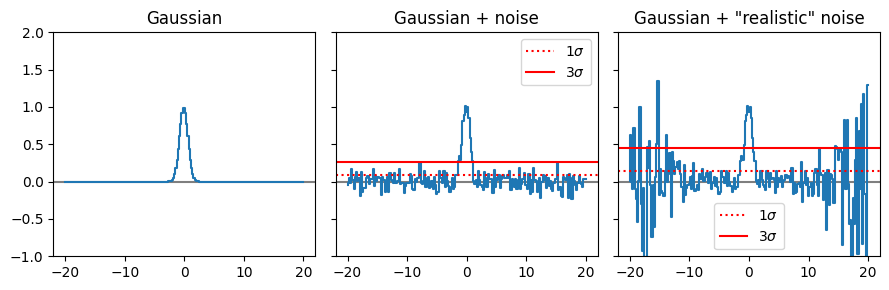

In [68]:
plt.figure(figsize=(9,3))
ax = plt.subplot(1,3,1)
ax.step(x_axis, spec)
ax.set_ylim(-1,2)
ax.axhline(0, zorder=0, color='k', alpha=.5)
ax.set_title('Gaussian')

ax = plt.subplot(1,3,2)
ax.step(x_axis, spec_noise)
ax.set_ylim(-1,2)
ax.set_yticklabels([])
ax.axhline(0, zorder=0, color='k', alpha=.5)
ax.set_title('Gaussian + noise')
ax.axhline(rms_spec, color='r', ls=':', label=r'1$\sigma$')
ax.axhline(3*rms_spec, color='r', label=r'3$\sigma$')
ax.legend()

ax = plt.subplot(1,3,3)
ax.step(x_axis, spec_noise_realistic)
ax.set_ylim(-1,2)
ax.set_yticklabels([])
ax.axhline(0, zorder=0, color='k', alpha=.5)
ax.set_title('Gaussian + "realistic" noise')
ax.axhline(rms_spec_realnoise, color='r', ls=':', label=r'1$\sigma$')
ax.axhline(3*rms_spec_realnoise, color='r', label=r'3$\sigma$')
ax.legend()

plt.tight_layout()

**Step 2: Defining a mask**

* We define a high and a low mask at different S/N thresholds
* The high mask (S/N>4) ensures that only real emisison is included
* The low mask ensures (S/N>2), that we do not clipp away too much emission.
* We then take the high mask and expand it into the low mask

In [88]:
high_tresh = 4
low_tresh = 2

mask = np.array(spec_noise > high_tresh * rms_spec, dtype = int)
low_mask = np.array(spec_noise > low_tresh * rms_spec, dtype = int)

mask_realistic = np.array(spec_noise_realistic > high_tresh * rms_spec_realnoise, dtype = int)
low_mask_realistic = np.array(spec_noise_realistic > low_tresh * rms_spec_realnoise, dtype = int)

**remove spikes** We want to make sure that single spikes above the threshold are not included in our mask. For this, we shift the spectra to the left and right and check if the overlap still is significant per channel (which would indicate that at least three consecutive channels are significantly detected.

In [89]:
#remove spikes along spectral axis:
mask = np.array((mask + np.roll(mask, 1) + np.roll(mask, -1))>=3, dtype = int)
low_mask = np.array((low_mask + np.roll(low_mask, 1) + np.roll(low_mask, -1))>=3, dtype = int)

mask_realistic = np.array((mask_realistic + np.roll(mask_realistic, 1) + np.roll(mask_realistic, -1))>=3, dtype = int)
low_mask_realistic = np.array((low_mask_realistic + np.roll(low_mask_realistic, 1) + np.roll(low_mask_realistic, -1))>=3, dtype = int)

**Expand channel-wise the high mask into the low mask**

In [92]:
for kk in range(12):
    mask = np.array(((mask + np.roll(mask, 1) + np.roll(mask, 1)) >= 1), dtype = int)*low_mask
    mask_realistic = np.array(((mask_realistic + np.roll(mask_realistic, 1) + np.roll(mask_realistic, 1)) >= 1), dtype = int)*low_mask_realistic

# Further expand the mask a few channels to include the wings
#expand to cover part of edge of the emission line
for kk in range(6):
    mask = np.array(((mask + np.roll(mask, 1) + np.roll(mask, -1)) >= 1), dtype = int)
    mask_realistic = np.array(((mask_realistic + np.roll(mask_realistic, 1) + np.roll(mask_realistic, -1)) >= 1), dtype = int)
    
   

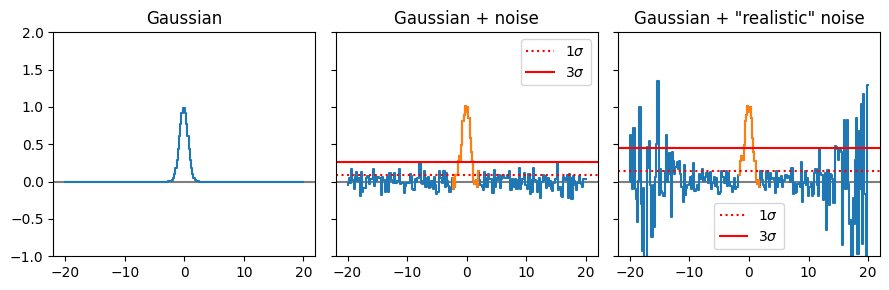

In [93]:
plt.figure(figsize=(9,3))
ax = plt.subplot(1,3,1)
ax.step(x_axis, spec)
ax.set_ylim(-1,2)
ax.axhline(0, zorder=0, color='k', alpha=.5)
ax.set_title('Gaussian')

ax = plt.subplot(1,3,2)
ax.step(x_axis, spec_noise)
ax.step(x_axis[mask==1], spec_noise[mask==1])
ax.set_ylim(-1,2)
ax.set_yticklabels([])
ax.axhline(0, zorder=0, color='k', alpha=.5)
ax.set_title('Gaussian + noise')
ax.axhline(rms_spec, color='r', ls=':', label=r'1$\sigma$')
ax.axhline(3*rms_spec, color='r', label=r'3$\sigma$')
ax.legend()

ax = plt.subplot(1,3,3)
ax.step(x_axis, spec_noise_realistic)
ax.step(x_axis[mask_realistic==1], spec_noise_realistic[mask_realistic==1])
ax.set_ylim(-1,2)
ax.set_yticklabels([])
ax.axhline(0, zorder=0, color='k', alpha=.5)
ax.set_title('Gaussian + "realistic" noise')
ax.axhline(rms_spec_realnoise, color='r', ls=':', label=r'1$\sigma$')
ax.axhline(3*rms_spec_realnoise, color='r', label=r'3$\sigma$')
ax.legend()

plt.tight_layout()

The orange part of the spectrum shows the significantly detected channels, that we include in the end for the moment-0 calculation. Note that even for the "realistic noise" example, we pick up only the real line emission.

**Step 3: Integrate over the masked channels only**

In [95]:
moment_0_spec = np.nansum(spec)*delta_v
moment_0_spec_noise = np.nansum(spec_noise*mask)*delta_v
moment_0_spec_noise_real = np.nansum(spec_noise_realistic*mask_realistic)*delta_v

print('Moment-0 ideal spectrum:\t\t %.3f [a.u]'%moment_0_spec )
print('Moment-0 simple noise spectrum:\t\t %.3f [a.u]'%moment_0_spec_noise )
print('Moment-0 ralistic noise spectrum:\t %.3f [a.u]'%moment_0_spec_noise_real )

Moment-0 ideal spectrum:		 1.772 [a.u]
Moment-0 simple noise spectrum:		 1.661 [a.u]
Moment-0 ralistic noise spectrum:	 1.657 [a.u]


The moment-0 values, in particular for the realistic noise example, do now agree more with the expected value

## Application to a 3D data cube

**Step 1: Import the data cube**

In [98]:
from spectral_cube import SpectralCube
import astropy.units as u

filename = './data/ngc5194_co21.fits'
cube = SpectralCube.read(filename, format='fits')

# Convert to km/s for the spectral unit
cube = cube.with_spectral_unit(u.km / u.s)

**Step 2: Calculate the rms**

In [120]:
mad_std_map = cube.mad_std(axis=0)
mad_std_map = cube.with_mask(cube<3*mad_std_map).mad_std(axis=0)

/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)


In [127]:
# Make a low and high mask
low_snr_mask = (cube > 2 * mad_std_map).include()
high_snr_mask = (cube > 4 * mad_std_map).include()

#remove spikes along spectral axis
high_snr_mask = high_snr_mask & np.roll(high_snr_mask,1,0)& np.roll(high_snr_mask,-1,0)
low_snr_mask = low_snr_mask & np.roll(low_snr_mask,1,0)& np.roll(low_snr_mask,-1,0)

**Step 3: Remove spatially spurious detections**
Note that this was not necessary for the 1D example, however, now in 3D, we remove spikes by making sure that in 2D, connected regions are larger than a given size.

We will label connected regions in `low_snr_mask` and label them. `low_snr_mask` and `high_snr_mask` are both dask arrays. We define regions as connected as 26-connected, meaning all edge and corner connections are included in 3D. The equivalent in 2D is 8-connected and would have a structure element like:

```
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
```

In [128]:
import scipy.ndimage as nd

structure = np.ones((3, 3, 3), dtype=bool)

low_snr_mask_labels, num_labels = nd.label(low_snr_mask,
                                           structure=structure)

print(f"Initial number of regions found: {num_labels}")



Initial number of regions found: 170


To remove spurious regions, we will apply 2 criteria:

1. All regions in `low_snr_mask` must contain $>10$ pixels above $6\sigma$ (the `high_snr_mask`). To do this, we calculate the sum of `high_snr_mask` within the `low_snr_mask_labels`.
2. Regions in `low_snr_mask` must contain $>110$ pixels. Similarly, we calculate the sum of `low_snr_mask` within the `low_snr_mask_labels`. 110 pixels in our example is about the number of pixels in the beam.

Regions that do not satisfy these criteria are removed from the mask.

The exact number of pixels for each criteria are approximate only and determined by checking different thresholds. A good rule-of-thumb is for regions in `low_snr_mask` to be greater than the number of pixels in the beam. $110$ pixels is approximately the number of pixels within the FWHM of the beam for these data, and so is the minimum number we expect for real signal within 1 spectral channel.

In [129]:
import scipy.ndimage as nd

num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                     labels=low_snr_mask_labels,
                                     index=range(1, num_labels + 1)) # +1 offset for mask labels

# Repeat for the high signal mask.
num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                    labels=low_snr_mask_labels,
                                    index=range(1, num_labels + 1)) # +1 offset for mask labels

# To preserve the low_snr_mask, we will create a new signal mask where we will remove 
# regions that do not pass the criteria.
signal_mask = low_snr_mask

low_min_pixels = 110
high_min_pixels = 40

for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, num_pixels_in_low_snr_mask)):
    if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
        # This region passes the criteria. Keep it in the mask.
        continue

    # Remove regions that do not pass the criteria.
    # NOTE: enumerate will start with 0, but the mask labels start at 1
    # We apply a +1 offset to `num` to account for this.
    signal_mask[low_snr_mask_labels == num + 1] = False


In [130]:
signal_mask_labels, num_labels = nd.label(signal_mask,
                                          structure=structure)

print(f"Final number of regions found: {num_labels}")

Final number of regions found: 1


Nearly every region we initially found was likely spurious, and far fewer regions remain that are more likely to be "real" CO emission from our source.

Before examining this new signal mask, we can apply an additional step to improve the recovery of faint emission near bright signal. Because we have imposed at $>3\sigma$ criterion in the low signal mask, some faint emission adjacent to the signal will be excluded and we will underestimate properties like the integrated intensity.

One simple way to correct for this is to extend the signal mask immediately around our remaining regions. We can extend the mask by one pixel in each dimension using [binary dilation](https://en.wikipedia.org/wiki/Dilation_%28morphology%29) to superimpose a structure element around every pixel included in the mask. With `dask-image`, we can use `ndmorph.binary_dilation`. 


In [131]:
# Use a structure that will increase the mask size by 1 pixel in each direction.
# Because we are applying it to the 3D cube, we need its size to be (3, 3, 3):

# In the spatial dimension, expand by 1 pixel in each direction.
# The structure looks like:
# [1, 1, 1]
# [1, 1, 1]
# [1, 1, 1]
structure = np.ones((3, 3), dtype=bool)

# In the spectral dimension, only expand the original pixel along the spectral dimension.
# The structure looks like:
# [0, 0, 0]
# [0, 1, 0]
# [0, 0, 0]

structure_spec = np.zeros((3, 3), dtype=bool)
structure_spec[1, 1] = True

# Add 1 spectral element on each side of the spatial structure.
# np.dstack stacks the arrays along a new 3rd dimension:
structure = np.dstack([structure_spec, structure, structure_spec])

# With scipy.ndimage:
# import scipy.ndimage as nd

signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)


At this point, we have finished computing the signal mask and now dask can execute the operations, returning a numpy array:


In [132]:
masked_cube = cube.with_mask(signal_mask)

/opt/homebrew/lib/python3.11/site-packages/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.115e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.531e+00 [aplpy.core]


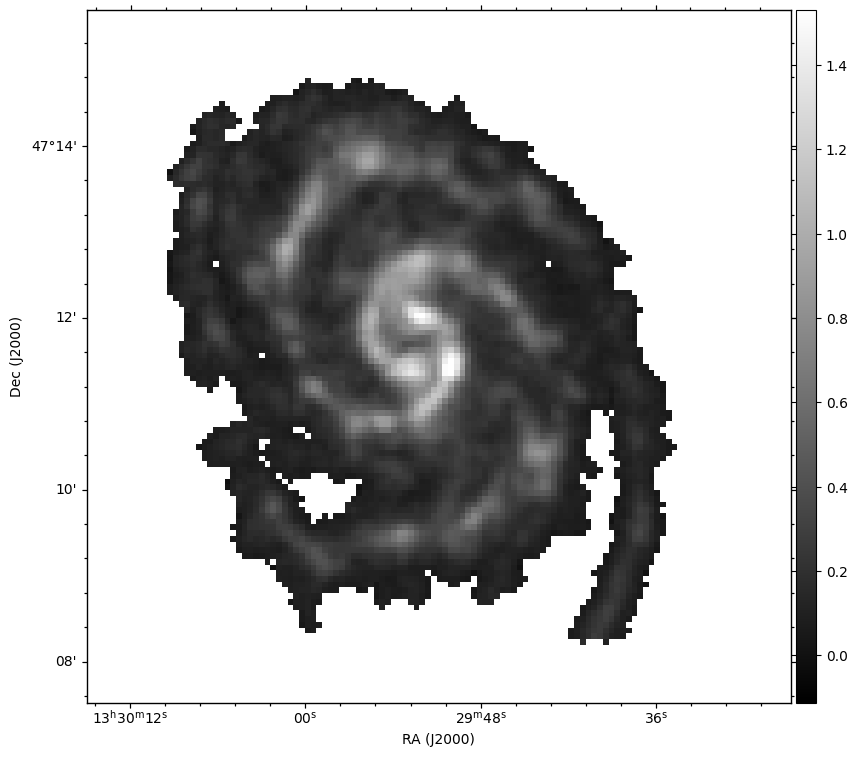

In [133]:
peak_intensity_sigmask = masked_cube.max(axis=0)

peak_intensity_sigmask.quicklook()

**Spectral Cube also has the option to easily calculate the moment-0 map**

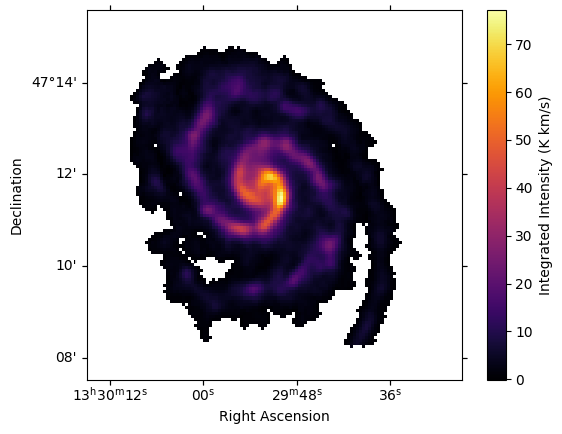

In [136]:
masked_moment0 = masked_cube.moment0()

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')